
<h3><center>Identificación de textos con lenguaje condescendiente</center></h3>

<h5><center>Martínez Ostoa Néstor I.<br> <i>Procesamiento de Lenguaje Natural</i> <br> 
    Facultad de Ingeniería <br>
    U.N.A.M.
</center></h5>

---

**Objetivo**: dado un párrafo, el sistema de PLN debe poder predecir si el párrafo contiene, o no, **lenguaje condescendiente**

**Corpus elegido:** Don't Patronize Me! corpus ([link](https://github.com/Perez-AlmendrosC/dontpatronizeme))

- Este corpus contiene $10,468$ párrafos extraídos de artículos de noticias con el objetivo principal de realizar un análisis para detectar lenguaje condescendiente (*patronizing and condescending language PCL*) en grupos socialmente vulnerables (refugiados, familias pobres, personas sin casa, etc)
- Cada uno de estos párrafos están anotados con etiquetas que indican el tipo de lenguaje PCL que se encuentra en él (si es que está presente). Los párrafos se extrajeron del corpus [News on Web (NOW)](https://www.english-corpora.org/now/)
- [Link al paper principal](https://aclanthology.org/2020.coling-main.518/)


**Estructura del corpus (original - antes del proceso de limpieza)**

- De manera general, el corpus contiene párrafos anotados con una etiqueta con valores entre $0$ y $4$ que indican el nivel de lenguaje PCL presente
- Cada instancia del corpus está conformada de la siguiente manera:
    - ```<doc-id>```: id del documento dentro del corpus NOW
    - ```<keyword>```: término de búsqueda utilizado para extraer textos relacionados con una comunidad en específico
    - ```<country-code>```: código de dos letras ISO Alpha-2
    - ```<paragraph>```: párrafo perteneciente al ```<keyword>```
    - ```<label>```: entero que indica el nivel de PCL presente
    
**Estructura del corpus actual (después del proceso de limpieza)**

- ```paragraph```: párrafo limpio sin stop words, signos de puntuación

### Bibliotecas requeridas

In [133]:
import numpy as np
import pandas as pd

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import graphviz

from textblob import TextBlob
from imblearn.over_sampling import SMOTE
import xgboost as xgb

from utils import plot_pcl_vs_no_pcl
import itertools

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, precision_score, recall_score, f1_score, precision_recall_fscore_support

### Datos

1. ```paragraph_df```: ```DataFrame``` de pandas con el párrafo y etiqueta (0,1) que indica si contiene o no lenguaje condescendiente
2. ```embeddings_dict```: diccionario de Python que contiene el _word embedding_ para cada palabra del corpus. Estos embeddings fueron previamente entrenados en el notebook **Lab-2-Word2Vec.ipynb**

In [60]:
CLEAN_DATA_PATH = "../data/dontpatronizeme_pcl_clean.tsv"
DATA_PATH = '../data/dontpatronizeme_v1.4/dontpatronizeme_pcl.tsv'
EMBEDDINGS_PATH = "../word-embeddings/embeddings.csv"

In [61]:
binary_df = pd.read_csv(
    DATA_PATH,
    skiprows=4,
    sep='\t',
    names=["par_id", "art_id", "keyword", "country_code","text","label"],
)
binary_df = binary_df.dropna()
del binary_df['art_id']
binary_df["label"] = binary_df["label"].transform(lambda x: 0 if x <= 1 else 1)
pcl_labels = binary_df['label'].value_counts()
print(f"Number of paragraphs without PCL: {pcl_labels[0]}")
print(f"Number of paragraphs with PCL   : {pcl_labels[1]}")

Number of paragraphs without PCL: 9475
Number of paragraphs with PCL   : 993


In [62]:
paragraph_df = pd.read_csv(CLEAN_DATA_PATH)
paragraph_df['label'] = binary_df['label']
print(f"Number of paragraphs: {paragraph_df.shape[0]}")
paragraph_df.head()

Number of paragraphs: 10468


,paragraph,label
0,living times absolute insanity pretty sure peo...,0.0
1,libya today countless number ghanaian nigerian...,0.0
2,white house press secretary sean spicer said f...,0.0
3,council customers signs would displayed two sp...,0.0
4,like received migrants fleeing el salvador gua...,0.0


In [63]:
embeddings_df = pd.read_csv(EMBEDDINGS_PATH)
print(f"{embeddings_df.shape}")
embeddings_df.head()

(12858, 2)


,word,embedding
0,aap,[0.72442698 0.8359355 0.70019351 0.55096675 0...
1,ababa,[0.77453578 0.76504 0.76891639 0.84648702 0...
2,abadies,[0.78254105 0.31335667 0.52573309 0.37820537 0...
3,abandon,[0.487395 0.49372098 0.51481443 0.94445999 0...
4,abandoned,[0.46609545 0.47762344 0.67915718 0.46457933 0...


In [64]:
def build_embeddings_dict(embeddings_df):
    """
    Parameters:
    -----------
    embeddings_df: Pandas' DataFrame
        - contains two columns: word and word embedding

    Returns:
    --------
    embeddings_dict: <dict>
        - key: word, value: Numpy's array with the word embedding values
    """
    embeddings_dict = dict()
    for _, row in embeddings_df.iterrows():
        word = row['word']
        word_embedding = []
        embedding = row['embedding'].replace('[', '').replace(']', '').replace('\n', ' ')
        for val in embedding.split(' '):
            if val != '':
                word_embedding.append(float(val))
        if word not in embeddings_dict:
            embeddings_dict[word] = np.array(word_embedding)
    return embeddings_dict
    
embeddings_dict = build_embeddings_dict(embeddings_df)    

In [65]:
w_embed = embeddings_dict['abandoned']
print(w_embed[:10])
print(w_embed.shape)

[0.46609545 0.47762344 0.67915718 0.46457933 0.4675923  0.42500885
 0.37786037 0.49812489 0.46607504 0.59231781]
(128,)


### Corpus de entrenamiento

- El corpus de entrenamiento tendrá las siguientes características:
  - **Párrafo**
  - **Word embedding para todo el párrafo**
    - Para construir este _word embedding_ tomé el _word embedding_ de cada palabra del párrafo y obtuve el promedio de todas las palabras del párrafo
  - **Polaridad**
    - Número real entre $0$ y $1$ que indica qué tan positivo ($1$) o negativo ($0$) es el párrafo
  - **Subjetividad**
    - Número real entre $0$ y $1$ que indica el nivel de subjetividad en el párrafo

In [66]:
def build_doc_vec(document, word_embeddings_dict, unknown_word_embedding):
    """
    Parameters:
    -----------
    document: <str>
        - document that may or may not contain PCL language
    
    word_embeddings_dict: <dict>
        - key: word, value: Numpy's ndarray with the word embedding

    unknown_word_embedding: <dict>
        - key: word, value: Numpy's ndarray with word embedding for unknown word

    Returns:
    --------
    doc_vec: <list>
        - Represents the embedding average of all the words within the document
    """

    # doc_vec construction
    doc_vec = []
    for word in document.split(' '):
        if word in word_embeddings_dict:
            doc_vec.append(word_embeddings_dict[word])
        # else:
        #     doc_vec.append(unknown_word_embedding)
    doc_vec = np.array(doc_vec)
    return np.mean(doc_vec, axis=0)


# word embedding for unknown words
unknown_word_embedding = []
for key in embeddings_dict.keys():
    unknown_word_embedding.append(embeddings_dict[key])
unknown_word_embedding = np.array(unknown_word_embedding)
unknown_word_embedding = np.mean(unknown_word_embedding, axis=0)

In [67]:
# Doc embeddings
paragraph_df['doc_embedding'] = paragraph_df['paragraph'].apply(
    lambda x: build_doc_vec(x, embeddings_dict, unknown_word_embedding)
)
paragraph_df.head()

,paragraph,label,doc_embedding
0,living times absolute insanity pretty sure peo...,0.0,"[0.4869072185416668, 0.48911817708333327, 0.49..."
1,libya today countless number ghanaian nigerian...,0.0,"[0.4608231631578948, 0.4880456889473685, 0.483..."
2,white house press secretary sean spicer said f...,0.0,"[0.47060307874999996, 0.481402148125, 0.447648..."
3,council customers signs would displayed two sp...,0.0,"[0.5236469664705882, 0.452554425882353, 0.6377..."
4,like received migrants fleeing el salvador gua...,0.0,"[0.531526278695652, 0.48318480347826087, 0.468..."


In [68]:
# Polaridad y subjetividad
paragraph_df["sentiment"] = paragraph_df["paragraph"].apply(
    lambda x: TextBlob(x).sentiment.polarity
)
paragraph_df["subjectivity"] = paragraph_df["paragraph"].apply(
    lambda x: TextBlob(x).sentiment.subjectivity
)
paragraph_df = paragraph_df[['paragraph', 'doc_embedding', 'sentiment', 'subjectivity', 'label']]
paragraph_df.head()

,paragraph,doc_embedding,sentiment,subjectivity,label
0,living times absolute insanity pretty sure peo...,"[0.4869072185416668, 0.48911817708333327, 0.49...",0.067361,0.467824,0.0
1,libya today countless number ghanaian nigerian...,"[0.4608231631578948, 0.4880456889473685, 0.483...",0.000000,0.750000,0.0
2,white house press secretary sean spicer said f...,"[0.47060307874999996, 0.481402148125, 0.447648...",-0.250000,0.250000,0.0
3,council customers signs would displayed two sp...,"[0.5236469664705882, 0.452554425882353, 0.6377...",-0.200000,0.300000,0.0
4,like received migrants fleeing el salvador gua...,"[0.531526278695652, 0.48318480347826087, 0.468...",0.200000,0.200000,0.0


In [89]:
doc_embed = pd.DataFrame(paragraph_df['doc_embedding'].to_list())
corpus_final_df = pd.concat([paragraph_df, doc_embed], axis=1)

del corpus_final_df['doc_embedding']
del corpus_final_df['paragraph']

label = corpus_final_df.pop('label')
corpus_final_df['label'] = label

corpus_final_df['label'].fillna(0, inplace=True)

corpus_final_df.head()

,sentiment,subjectivity,0,1,2,3,4,5,6,7,...,119,120,121,122,123,124,125,126,127,label
0,0.067361,0.467824,0.486907,0.489118,0.492924,0.529046,0.520375,0.523863,0.496424,0.484376,...,0.511040,0.501291,0.523022,0.508850,0.458311,0.437911,0.514549,0.477601,0.517328,0.0
1,0.000000,0.750000,0.460823,0.488046,0.483620,0.468189,0.452302,0.414142,0.491451,0.447040,...,0.547778,0.429446,0.526748,0.475683,0.629307,0.413422,0.456266,0.526150,0.440417,0.0
2,-0.250000,0.250000,0.470603,0.481402,0.447649,0.519795,0.418868,0.560837,0.416720,0.581265,...,0.527147,0.606056,0.503175,0.500745,0.466062,0.431881,0.470293,0.467286,0.518301,0.0
3,-0.200000,0.300000,0.523647,0.452554,0.637726,0.519798,0.459194,0.398197,0.459562,0.484419,...,0.438916,0.586857,0.412273,0.607066,0.548012,0.497471,0.443657,0.528045,0.438848,0.0
4,0.200000,0.200000,0.531526,0.483185,0.468296,0.563911,0.513563,0.509672,0.517133,0.519486,...,0.489404,0.572674,0.491366,0.590320,0.536766,0.451897,0.493557,0.608871,0.501298,0.0


### Entrenamiento del modelo

- Derivado que el corpus no está balanceado, hay que aplicar pasos de preprocesamiento extra para solucionar este problema
- El paso que seguí fue utilizar SMOTE (Synthetic Minority Oversampling Technique) el cual generará datos sintéticos de la clase minoritaria (párrafos con lenguaje condescendiente) para que el clasifcicador no tome un sesgo hacía la clase mayoritaria (párrafos sin lenguaje condescendiente)

#### Construcción del corpus balanceado

In [91]:
X, y = corpus_final_df.iloc[:, :-1], corpus_final_df.iloc[:, -1]
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

X shape: (10468, 130)
y shape: (10468,)


In [93]:
sm = SMOTE(random_state=0)
X, y = sm.fit_resample(X, y)
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

X shape: (18952, 130)
y shape: (18952,)


In [101]:
plot_pcl_vs_no_pcl(y)

#### División en corpus de entrenamiento y prueba

In [105]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (14214, 130)
y_train shape: (14214,)
X_test shape: (4738, 130)
y_test shape: (4738,)


#### Entrenamiento del modelo

In [109]:
dtrain = xgb.DMatrix(X_train, label=y_train)
param = {
    'eta': 0.1, 'objective': 'binary:logistic',
    'eval_metric': 'logloss'
}
num_round = 10
bst = xgb.train(param, dtrain, num_round)

#### Prueba del modelo

In [111]:
dtest = xgb.DMatrix(X_test)
y_pred = bst.predict(dtest)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

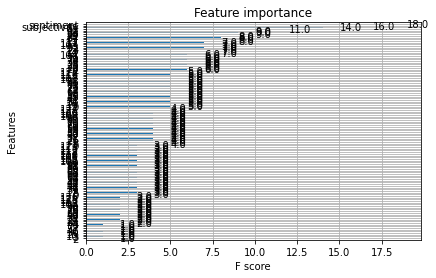

In [113]:
xgb.plot_importance(bst)

#### Evaluación del modelo

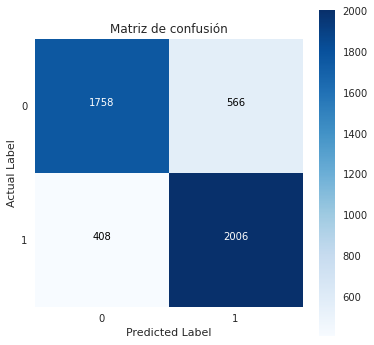

In [138]:
y_pred = [0 if val < 0.5 else 1 for val in y_pred]
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
with plt.style.context(('ggplot', 'seaborn')):
    fig = plt.figure(figsize=(6,6), num=1)
    plt.imshow(cm, interpolation='nearest',cmap= plt.cm.Blues)
    plt.xticks([0,1],[0,1])
    plt.yticks([0,1],[0,1])
    plt.xlabel('Predicted Label')
    plt.ylabel('Actual Label')
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if (i==0 and j == 1) or (i == 1 and j == 0): color = 'black'
        else: color = 'white'
        plt.text(j, i,cm[i, j], horizontalalignment="center", color=color)

    plt.grid(None)
    plt.title('Matriz de confusión')
    plt.colorbar()

In [139]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.81      0.76      0.78      2324
         1.0       0.78      0.83      0.80      2414

    accuracy                           0.79      4738
   macro avg       0.80      0.79      0.79      4738
weighted avg       0.80      0.79      0.79      4738



#### Ejemplo concreto

In [250]:
random_index = X_test.sample(n=1).index.values[0]
while random_index not in paragraph_df.index:
    random_index = X_test.sample(n=1).index.values[0]
tdf = paragraph_df.loc[[random_index]][['paragraph', 'label']]
test_paragraph, real_label = tdf['paragraph'].values[0], tdf['label'].values[0]
print(f"=== Paragraph example ===\n{test_paragraph.capitalize()}")
print(f"\n=== Real Label (0: No PCL, 1: PCL) ===\n\t{real_label}")

=== Paragraph example ===
Pga america stripped grand slam golf trump national los angeles trump comments mexican immigrants event later discontinued

=== Real Label (0: No PCL, 1: PCL) ===
	0.0


In [251]:
y_pred_ = bst.predict(
    xgb.DMatrix(X_test.loc[[random_index]])
)[0]
if y_pred_ < 0.5:
    print(f"=== Model prediction ===\n\tNO PCL\n\t{y_pred_}")
else:
    print(f"=== Model prediction ===\n\tPCL\n\t{y_pred_}")

=== Model prediction ===
	NO PCL
	0.30601516366004944
